## Importing and creating train features

In [1]:
import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

In [10]:
#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

160000


,text,label
3533945,usability and programming history: This was a ...,1
302956,This case is pretty good: Fits gameboy with Pe...,2
3086621,"Bones Reds are awesome!: I got these today, an...",2
946241,This cd rocks hard: i love this cd i can turn ...,2
2803661,Too tough: Since I really loved Buffalo Bill's...,1


In [11]:
#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


In [12]:
#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

In [13]:
model_w2v.save('model_w2v.bin')

In [14]:
#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

In [15]:
for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

In [16]:
text_avg_vec[0]

array([-2.39594962e-02, -3.52297321e-01,  1.82629284e-01,  3.50403552e-02,
       -3.42428980e-01,  2.96911069e-01,  3.62364998e-01, -1.40412820e-01,
       -2.38565522e-01, -9.53779967e-02, -7.59008595e-02,  2.46695624e-03,
       -5.98871699e-02, -3.29450190e-01, -1.35016516e-01, -1.41912155e-01,
        2.55528346e-02,  3.11567659e-01, -2.08746480e-01,  1.05372929e-01,
        1.42134485e-01, -1.61325655e-01,  9.18009292e-03,  1.58887904e-01,
        4.95492782e-01,  1.53667141e-01, -3.70266686e-01,  3.57450015e-01,
        1.26190499e-01, -3.48605867e-01, -2.21555804e-01, -1.99812797e-01,
        1.80274532e-01,  6.28552006e-01, -1.89942103e-01,  4.37229785e-01,
        8.32161781e-02, -1.19431146e-01, -7.16513588e-01, -2.51545378e-01,
        4.79025925e-01, -2.21111028e-01, -3.15386977e-04,  2.27327358e-01,
       -2.21959181e-01,  1.63623010e-01,  3.95685532e-01, -1.00819586e-01,
       -7.88121291e-01,  2.45670173e-01,  1.90602971e-01, -2.31535771e-01,
        1.95498465e-02,  

In [17]:
x_train = text_avg_vec
#x_train = np.c_[x_train]

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(len(x_train))
print(len(x_val))

120000
40000


## Modeling

In [18]:
#Logistic Regression Training

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

lr = LogisticRegression().fit(x_train, y_train)

C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
#Naive Bayes Training

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(x_train, y_train)

In [ ]:
#Deep Neural net Training

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

# mini batches Nadam optimizer with dropout and batch normalization
epochs = 100
model = tf.keras.Sequential()
model.add(layers.Dense(32, input_dim=100))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.4))

model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN.model", monitor='val_accuracy', verbose=1, save_best_only=True)

model.summary()
model1 = model.fit(x_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])
#history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                3232      
_________________________________________________________________
activation_14 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)               

In [ ]:
x_train1 = x_train.reshape(120000, x_train.shape[1], 1)
print(x_train1.shape)

(120000, 100, 1)


In [ ]:
#CNN Training

import tensorflow as tf

shape = (x_train.shape[1], 1)
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation=tf.nn.relu, input_shape=shape))
model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation=tf.nn.relu))

model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
          
model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation=tf.nn.relu))
model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation=tf.nn.relu))
          
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
          
model.add(tf.keras.layers.Conv1D(128, kernel_size=3, activation=tf.nn.relu))
model.add(tf.keras.layers.Conv1D(128, kernel_size=3, activation=tf.nn.relu))
          
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
          
model.add(tf.keras.layers.Conv1D(256, kernel_size=3, activation=tf.nn.relu))
model.add(tf.keras.layers.Conv1D(256, kernel_size=3, activation=tf.nn.relu))
          
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
          
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("CNN.model", monitor='val_accuracy', verbose=1, save_best_only=True)
model2 = model.fit(x_train1, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint])

Train on 96000 samples, validate on 24000 samples
Epoch 1/100
95840/96000 [============================>.] - ETA: 0s - loss: 0.4179 - accuracy: 0.8086
Epoch 00001: val_accuracy improved from -inf to 0.83017, saving model to CNN.model
INFO:tensorflow:Assets written to: CNN.model/assets
96000/96000 [==============================] - 19s 201us/sample - loss: 0.4180 - accuracy: 0.8086 - val_loss: 0.3828 - val_accuracy: 0.8302
Epoch 2/100
95840/96000 [============================>.] - ETA: 0s - loss: 0.3789 - accuracy: 0.8310
Epoch 00002: val_accuracy did not improve from 0.83017
96000/96000 [==============================] - 17s 179us/sample - loss: 0.3788 - accuracy: 0.8311 - val_loss: 0.4988 - val_accuracy: 0.7315
Epoch 3/100
95872/96000 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8375
Epoch 00003: val_accuracy improved from 0.83017 to 0.84704, saving model to CNN.model
INFO:tensorflow:Assets written to: CNN.model/assets
96000/96000 [==========================

## Load test features

In [76]:
#Load and Clean test file

text_file = open("test.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')

df = df.sample(40000)

In [70]:
#Embed Word2Vec and BOW

from tqdm import tqdm_notebook as tqdm

text = [row.split() for row in df['text']]
text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [71]:
for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

In [45]:
x_test = text_avg_vec
#x_test = np.c_[x_test]

df['label'] = df['label'] - 1

## Evaluation

In [27]:
#Logistic Regression Results

predicted = lr.predict(x_test)

df['prediction'] = predicted

In [29]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.84831461 0.8540179 ]
recall: [0.85460282 0.84770889]
fscore: [0.85144711 0.8508517 ]
support: [19966 20034]


In [30]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.85115
False pos: 0.072575
False neg: 0.076275


In [22]:
#Naive Bayes Results

predicted = clf.predict(x_test)

df['prediction'] = predicted

In [23]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.731675
False pos: 0.13345
False neg: 0.134875


In [24]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.72965524 0.73368589]
recall: [0.73174531 0.73160539]
fscore: [0.73069878 0.73264416]
support: [19899 20101]


In [ ]:
#Deep neural network Results

nn_model = tf.keras.models.load_model('NN.model')
predicted = nn_model.predict_classes(x_test)
df['prediction'] = predicted

In [ ]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.861675
False pos: 0.069775
False neg: 0.06855


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.86253572 0.86081883]
recall: [0.86042208 0.86292741]
fscore: [0.86147761 0.86187183]
support: [19996 20004]


In [ ]:
#CNN Results

x_test1 = x_test.reshape(40000, x_test.shape[1], 1)

cnn_model = tf.keras.models.load_model('CNN.model')
predicted = cnn_model.predict_classes(x_test1)
df['prediction'] = predicted

In [ ]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.854125
False pos: 0.072325
False neg: 0.07355


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.85323023 0.8550238 ]
recall: [0.85532106 0.85292941]
fscore: [0.85427437 0.85397532]
support: [19996 20004]


In [ ]:
#Training SVM

from sklearn import svm

svm_model = svm.SVC(kernel='linear')

svm_model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
import pickle
# save the classifier
with open('svm_model.pkl', 'wb') as fid:
    pickle.dump(svm_model, fid)    

In [ ]:
#SVM Results

predicted = svm_model.predict(x_test)
df['prediction'] = predicted

In [ ]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.849375
False pos: 0.071425
False neg: 0.0792


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.84399468 0.85492307]
recall: [0.85712142 0.84163167]
fscore: [0.85050741 0.84822531]
support: [19996 20004]


In [ ]:
#Training Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=456)

rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=456,
                       verbose=0, warm_start=False)

In [ ]:
#Random Forest Results

predicted = rf.predict(x_test)
df['prediction'] = predicted

In [ ]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.832175
False pos: 0.078425
False neg: 0.0894


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.82500612 0.83966266]
recall: [0.84311862 0.82123575]
fscore: [0.83396404 0.83034699]
support: [19996 20004]


In [ ]:
#Training second layer Random Forest (Combined models)

lr_predict = lr.predict(x_train)
nb_predict = clf.predict(x_train)
svm_predict = svm_model.predict(x_train)
rf_predict = rf.predict(x_train)
nn_predict = nn_model.predict_classes(x_train)
cnn_predict = cnn_model.predict_classes(x_train1)

In [ ]:
new_features = pd.DataFrame()
new_features['lr_predict'] = lr_predict
new_features['nb_predict'] = nb_predict
new_features['svm_predict'] = svm_predict
new_features['rf_predict'] = rf_predict
new_features['nn_predict'] = nn_predict
new_features['cnn_predict'] = cnn_predict

new_features.head()

,lr_predict,nb_predict,svm_predict,rf_predict,nn_predict,cnn_predict
0,0,0,0,0,0,0
1,1,1,1,1,1,1
2,1,0,1,0,1,1
3,1,1,1,1,1,1
4,1,0,1,1,1,1


In [ ]:
rf_2 = RandomForestClassifier(n_estimators=500, criterion='entropy')

rf_2.fit(new_features, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Combined model results (2nd layer Random Forest)

lr_predict = lr.predict(x_test)
nb_predict = clf.predict(x_test)
svm_predict = svm_model.predict(x_test)
rf_predict = rf.predict(x_test)
nn_predict = nn_model.predict_classes(x_test)
cnn_predict = cnn_model.predict_classes(x_test1)

In [ ]:
new_features = pd.DataFrame()
new_features['lr_predict'] = lr_predict
new_features['nb_predict'] = nb_predict
new_features['svm_predict'] = svm_predict
new_features['rf_predict'] = rf_predict
new_features['nn_predict'] = nn_predict
new_features['cnn_predict'] = cnn_predict

new_features.head()

,lr_predict,nb_predict,svm_predict,rf_predict,nn_predict,cnn_predict
0,1,1,1,1,1,1
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,1,1,1,1,1
4,0,0,0,0,0,0


In [ ]:
predicted = rf_2.predict(new_features)
df['prediction'] = predicted

In [ ]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.832175
False pos: 0.078425
False neg: 0.0894


In [ ]:
predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.82500612 0.83966266]
recall: [0.84311862 0.82123575]
fscore: [0.83396404 0.83034699]
support: [19996 20004]


In [ ]:
#Trial: Training deep neural net as second layer (Combined models)

lr_predict_train = lr.predict(x_train)
nb_predict_train = clf.predict(x_train)
svm_predict_train = svm_model.predict(x_train)
rf_predict_train = rf.predict(x_train)
nn_predict_train = nn_model.predict_classes(x_train)
cnn_predict_train = cnn_model.predict_classes(x_train1)

new_features_train = pd.DataFrame()
new_features_train['lr_predict'] = lr_predict_train
new_features_train['nb_predict'] = nb_predict_train
new_features_train['svm_predict'] = svm_predict_train
new_features_train['rf_predict'] = rf_predict_train
new_features_train['nn_predict'] = nn_predict_train
new_features_train['cnn_predict'] = cnn_predict_train

new_features_train.head()

,lr_predict,nb_predict,svm_predict,rf_predict,nn_predict,cnn_predict
0,0,0,0,0,0,0
1,1,1,1,1,1,1
2,1,0,1,0,1,1
3,1,1,1,1,1,1
4,1,0,1,1,1,1


In [ ]:
# mini batches Nadam optimizer with dropout and batch normalization
epochs = 10
model = tf.keras.Sequential()
model.add(layers.Dense(16, input_dim=6))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(16))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.4))

model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN2.model", monitor='val_accuracy', verbose=1, save_best_only=True)

model.summary()
model1 = model.fit(new_features_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16)                112       
_________________________________________________________________
activation_28 (Activation)   (None, 16)                0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 16)                64        
_________________________________________________________________
dense_35 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_29 (Activation)   (None, 16)                0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16)                64        
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)               

In [ ]:
#Combined model results (Deep Neural Net 2nd Layer)

nn2_model = tf.keras.models.load_model('NN2.model')
predicted = nn2_model.predict_classes(new_features)
df['prediction'] = predicted

In [ ]:
count_true = 0
false_pos = 0
false_neg = 0

for index, row in df.iterrows():
    if row['label'] == row['prediction']:
        count_true = count_true + 1
    elif row['label'] == 0 and row['prediction'] == 1:
        false_pos = false_pos + 1
    elif row['label'] == 1 and row['prediction'] == 0:
        false_neg = false_neg + 1

print("Accuracy on test set: " + str(count_true/len(df)))
print("False pos: " + str(false_pos/len(df)))
print("False neg: " + str(false_neg/len(df)))

Accuracy on test set: 0.832175
False pos: 0.078425
False neg: 0.0894


In [ ]:
predicted = predicted 
y_test = df['label']

precision, recall, fscore, support = score(y_test, predicted, labels=[0, 1])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.82500612 0.83966266]
recall: [0.84311862 0.82123575]
fscore: [0.83396404 0.83034699]
support: [19996 20004]


## Logistic Regression Extension

### CV Simple LogReg

In [66]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=200)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)

In [67]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

84.93% (+/- 0.45%)


### Logistic GridSearchCV for L2 and no penalty with compatible solvers

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=10):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=1)

    fitted = gs.fit(X_train, y_train)
    pred = fitted.predict(X_test)

    return fitted, pred


param_grid = {'penalty':['l2','none'], 'C':[0.5,0.8,1.0,1.2], 'random_state':[42], 'solver':['newton-cg','lbfgs','sag','saga']}

model = LogisticRegression(n_jobs=-1)

model, pred = pipeline(x_train, x_val, y_train, y_val, model, param_grid, cv=10)

print(model.best_score_)
print(model.best_params_)



Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\danie\anaconda3\lib\site-packa

AttributeError: 'GridSearchCV' object has no attribute 'best_score'

In [45]:
print(model.best_score_)
print(model.best_params_)

0.8504166666666666
{'C': 0.5, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag'}


### GridSearchCV for L1 L2 with liblinear and saga

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=10):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=1)

    fitted = gs.fit(X_train, y_train)
    pred = fitted.predict(X_test)

    return fitted, pred

param_grid = {'penalty':['l1','l2'], 'C':[0.5,0.8,1.0,1.2], 'random_state':[42], 'solver':['liblinear','saga']}

model = LogisticRegression(n_jobs=-1)

model, pred = pipeline(x_train, x_val, y_train, y_val, model, param_grid, cv=10)

print(model.best_score_)
print(model.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.

0.849725
{'C': 0.8, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}


### Saga with Elasticnet

In [16]:
param_grid = {'penalty':['elasticnet'], 'C':[0.5,0.8,1.0,1.2], 'random_state':[42], 'solver':['saga'], 'l1_ratio':[0.2,0.4,0.6,0.8]}

model = LogisticRegression(n_jobs=-1)

model, pred = pipeline(x_train, x_val, y_train, y_val, model, param_grid, cv=10)

print(model.best_score_)
print(model.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 11.6min finished


AttributeError: 'GridSearchCV' object has no attribute 'best_score'

In [17]:
print(model.best_score_)
print(model.best_params_)

0.8497333333333333
{'C': 0.5, 'l1_ratio': 0.4, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga'}


### Evaluate on test set with simple logreg and best params log reg

In [58]:
simple_logreg = LogisticRegression(random_state=42, max_iter=200)
best_logreg = LogisticRegression(C=0.5, random_state=42, solver='sag')

simple_logreg.fit(x_train, y_train)
best_logreg.fit(x_train, y_train)

predicted_simple = simple_logreg.predict(x_test)
predicted_best = best_logreg.predict(x_test)

In [59]:
simple_logreg.score(x_test, y_test)

0.851175

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_simple))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     19966
           1       0.85      0.85      0.85     20034

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



In [61]:
best_logreg.score(x_test, y_test)

0.85115

In [62]:
print(classification_report(y_test, predicted_best))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     19966
           1       0.85      0.85      0.85     20034

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



In [63]:
print(simple_logreg.score(x_val, y_val))
print(best_logreg.score(x_val, y_val))

0.851825
0.8517


### Modifications with ElasticNet L1 ratio and other parameter tuning

In [51]:
from sklearn.linear_model import LogisticRegression
import numpy as np

elastic_logreg = LogisticRegression(penalty='elasticnet', C=(1+np.sqrt(5))/2, random_state=42, solver='saga', l1_ratio=0.6)

elastic_logreg.fit(x_train, y_train)
print(elastic_logreg.score(x_val, y_val))

0.8526


In [46]:
from sklearn.metrics import classification_report

y_test = df['label']
predicted = elastic_logreg.predict(x_test)

print(elastic_logreg.score(x_test, y_test))
print(classification_report(y_test, predicted))




0.850825
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     20318
           1       0.85      0.85      0.85     19682

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



In [49]:
elastic_logreg_1 = LogisticRegression(penalty='elasticnet', C=1/((1+np.sqrt(5))/2), random_state=42, solver='saga', l1_ratio=0.4)

elastic_logreg_1.fit(x_train, y_train)
print(elastic_logreg_1.score(x_val, y_val))

0.852525


In [50]:
predicted = elastic_logreg_1.predict(x_test)

print(elastic_logreg_1.score(x_test, y_test))
print(classification_report(y_test, predicted))

0.850775
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     20318
           1       0.85      0.85      0.85     19682

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



## Combined features

### Creating train features

In [1]:
import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

In [2]:
#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

160000


,text,label
2700725,Bringing out the hidden complexity of Haydn: T...,2
2119872,Not worth the money or the wait: I picked up t...,1
3522157,Great Grilling: Bought this griil for my son a...,2
2657983,Attractive and Good Quality: This pewter bear ...,2
713772,not worth a penny: I wore these boots for the ...,1


In [3]:
#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


In [4]:
#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

In [5]:
model_w2v.save('model_w2v.bin')

In [6]:
#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [7]:
for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

In [8]:
text_avg_vec[0]

array([-0.40853754, -0.38679563, -0.95826751, -0.3337734 , -0.20393041,
       -0.22012257, -0.32521616, -0.17680886,  0.12652912,  0.53451511,
        0.09845188,  0.00559624, -0.56184483,  0.13195313, -0.93501698,
        0.13119618,  0.34067749, -0.66382934,  0.27455967, -0.61961251,
       -0.01541351, -0.08719711, -0.03395919,  0.2928971 ,  0.4032096 ,
        0.45737276, -0.2549706 ,  0.30731208, -0.42949031, -0.10682201,
       -0.05644133,  0.10391716, -0.05313593, -0.48116139, -0.0093661 ,
        0.24171149,  0.78481103, -0.04739485,  0.02662561, -0.32518936,
       -0.79016119,  0.4302174 ,  0.22235376, -0.54802614, -0.1610888 ,
       -0.41376326,  0.20082239, -0.57389326, -0.07668226,  1.01035403,
       -0.14983318, -0.08995562,  0.13779828, -0.05832776, -0.87467947,
       -0.22567286, -0.43352613, -0.17384305, -0.21771592,  0.60231309,
       -0.01061233, -0.61366194, -0.60999509, -0.13262224, -0.26967327,
        0.03996115,  0.65497345, -0.22238656, -0.04122111,  0.11

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2900)

tfidf_features = tfidf.fit_transform(df['text'])

In [9]:
tfidf_features.shape

(160000, 2900)

In [10]:
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)
x_train.shape

(160000, 100)

In [11]:
x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)
x_train.shape

(160000, 3000)

In [12]:
df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(len(x_train))
print(len(x_val))

120000
40000


### Default Logistic Regression on new combined features

In [ ]:
# 3000 features total

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

88.31% (+/- 0.31%)


In [14]:
# 5000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=4900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [15]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

88.73% (+/- 0.22%)


In [16]:
#7500 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=7400)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [17]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

88.90% (+/- 0.26%)


In [18]:
# 10,000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=9900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [19]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.00% (+/- 0.27%)


In [20]:
# 15,000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=14900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [21]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.09% (+/- 0.20%)


In [22]:
# 20,000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=19900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [23]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.12% (+/- 0.23%)


In [25]:
#30,000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

x_train = np.concatenate((x_train, tfidf_features.toarray()), axis=1)

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [26]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.18% (+/- 0.23%)


In [23]:
# 40,000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=39900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)
x_train = sparse.csr_matrix(x_train)

x_train = sparse.hstack([x_train, tfidf_features])

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [24]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.14% (+/- 0.12%)


In [30]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.12% (+/- 0.19%)


In [26]:
# 50,000 features total

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=49900)

tfidf_features = tfidf.fit_transform(df['text'])
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)
x_train = sparse.csr_matrix(x_train)

x_train = sparse.hstack([x_train, tfidf_features])
y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

In [27]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.12% (+/- 0.15%)


In [ ]:
# 2000 features total

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

x_train = np.array(x_train)
y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

87.92% (+/- 0.23%)


In [75]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
xtrain = vectorizer.fit_transform(df['text'])

ytrain= np.asarray(df.label)

from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=40000, random_state=42)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [78]:
xtest = vectorizer.transform(df['text'])
ytest = df['label'] - 1
ytrain = ytrain - 1

In [80]:
yval = yval-1

In [81]:
logreg_eval = LogisticRegression(random_state=42, max_iter=2000)

logreg_eval.fit(xtrain, ytrain)

print(logreg_eval.score(xval, yval))
print(logreg_eval.score(xtest, ytest))


0.888925
0.88775


In [82]:
xtrain.shape

(120000, 3406721)

### Full TFIDF + Word2Vec

#### Training file prep

In [2]:
#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')

160000


In [3]:
#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

In [4]:
#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0
    
for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tfidf.fit_transform(df['text'])

tfidf_train

<160000x3404513 sparse matrix of type '<class 'numpy.float64'>'
	with 12033848 stored elements in Compressed Sparse Row format>

In [8]:
from scipy import sparse

x_train = sparse.csr_matrix(np.array(text_avg_vec).reshape(-1, 100))

x_train = sparse.hstack((x_train, tfidf_train))

y_train = df['label'] - 1

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

#### Test file prep

In [11]:
#Load and Clean test file

text_file = open("test.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')

df = df.sample(40000)

In [12]:
#Embed Word2Vec and BOW

from tqdm import tqdm_notebook as tqdm

text = [row.split() for row in df['text']]
text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [13]:
for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

In [14]:
tfidf_test = tfidf.transform(df['text'])
x_test = sparse.csr_matrix(np.array(text_avg_vec).reshape(-1, 100))

x_test = sparse.hstack((x_test, tfidf_test))

y_test = df['label'] - 1

print(x_test.shape)

(40000, 3404613)


#### Evaluate Default Logreg

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

y_train = np.array(y_train)

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

88.10% (+/- 0.29%)


### 30,000 features with Optimum Logreg from GridSearch

In [1]:
import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

C:\Users\danie\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\danie\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [43]:
#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

160000


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'])

In [9]:
tfidf_features

<160000x29900 sparse matrix of type '<class 'numpy.float64'>'
	with 6508195 stored elements in Compressed Sparse Row format>

In [45]:
x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

from scipy import sparse

x_train = sparse.csr_matrix(x_train)
x_train.shape

(160000, 100)

In [12]:
tfidf_features.shape

(160000, 29900)

In [46]:
x_train = sparse.hstack([x_train, tfidf_features])
x_train.shape

(160000, 30000)

In [47]:
df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(x_train.shape)
print(x_val.shape)

(120000, 30000)
(40000, 30000)


In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=2000)
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_val, y_val))

0.9164333333333333
0.89175


In [35]:
model = LogisticRegression(random_state=42, max_iter=2000, C=0.5, penalty='l2', solver='sag')
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_val, y_val))

0.9025416666666667
0.887975


In [22]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores=[]

for train_index, val_index in kf.split(x_train, y_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = LogisticRegression(random_state=42, max_iter=2000)
    model.fit(x_train_kf, y_train_kf)
    
    scores = model.score(x_val_kf, y_val_kf)
    cvscores.append(scores * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.15% (+/- 0.16%)


#### Test Load

In [49]:
#Load and Clean test file

text_file = open("test.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')

df = df.sample(40000)

In [50]:
#Embed Word2Vec and BOW

from tqdm import tqdm_notebook as tqdm

text = [row.split() for row in df['text']]
text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [51]:
for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

In [52]:
x_test = text_avg_vec
#x_test = np.c_[x_test]

df['label'] = df['label'] - 1

In [53]:
tfidf_features = tfidf.transform(df['text'])

x_test = np.array(text_avg_vec).reshape(-1, 100)
x_test = sparse.csr_matrix(x_test)
x_test = sparse.hstack([x_test, tfidf_features])

y_test = np.asarray(df['label'])

print((x_test.shape))

(40000, 30000)


In [54]:
from sklearn.metrics import classification_report

predicted = model.predict(x_test)

print(model.score(x_test, y_test))
print(classification_report(y_test, predicted))

0.8927
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     20068
           1       0.89      0.90      0.89     19932

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000



## Neural Net with new Features

### Constructing train features

In [1]:
import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'])

x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

from scipy import sparse

x_train = sparse.csr_matrix(x_train)
x_train.shape

x_train = sparse.hstack([x_train, tfidf_features])
x_train.shape

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(x_train.shape)
print(x_val.shape)

160000


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(120000, 30000)
(40000, 30000)


### Neural net training

In [5]:
import keras

y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='int32')
y_val = keras.utils.to_categorical(y_val, num_classes=2, dtype='int32')

Using TensorFlow backend.
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [7]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [10]:
#Deep Neural net Training

from keras import layers
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt

# mini batches Nadam optimizer with dropout and batch normalization
epochs = 10
model = keras.Sequential()
model.add(layers.Dense(32, input_dim=30000))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(rate = 0.4))

model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN.model", monitor='val_accuracy', verbose=1, save_best_only=True)

model.summary()
#model1 = model.fit(x_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])
#history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                960032    
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32)                128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [13]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 32, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/32,epochs=10)

Epoch 1/10
3750/3750 [==============================] - 99s 26ms/step - loss: 0.2772 - accuracy: 0.8855 - val_loss: 0.2656 - val_accuracy: 0.8908
Epoch 2/10
3750/3750 [==============================] - 132s 35ms/step - loss: 0.2220 - accuracy: 0.9126 - val_loss: 0.2736 - val_accuracy: 0.8847
Epoch 3/10
3750/3750 [==============================] - 170s 45ms/step - loss: 0.1800 - accuracy: 0.9299 - val_loss: 0.2790 - val_accuracy: 0.8911
Epoch 4/10
3750/3750 [==============================] - 193s 51ms/step - loss: 0.1431 - accuracy: 0.9442 - val_loss: 0.2914 - val_accuracy: 0.8897
Epoch 5/10
3750/3750 [==============================] - 193s 51ms/step - loss: 0.1169 - accuracy: 0.9549 - val_loss: 0.3412 - val_accuracy: 0.8825
Epoch 6/10
3750/3750 [==============================] - 185s 49ms/step - loss: 0.0956 - accuracy: 0.9634 - val_loss: 0.3945 - val_accuracy: 0.8856
Epoch 7/10
3750/3750 [==============================] - 184s 49ms/step - loss: 0.0797 - accuracy: 0.9701 - val_loss: 0.

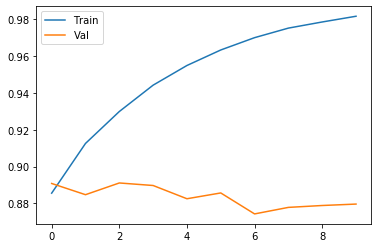

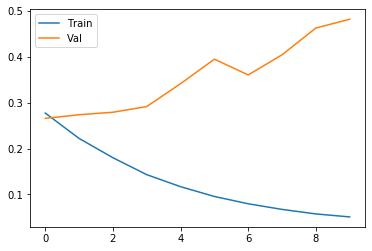

In [14]:
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [15]:
# mini batches Nadam optimizer with dropout and batch normalization
epochs = 10
model = keras.Sequential()
model.add(layers.Dense(32, input_dim=30000))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN.model", monitor='val_accuracy', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 32)                960032    
_________________________________________________________________
batch_normalization_19 (Batc (None, 32)                128       
_________________________________________________________________
activation_22 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_23 (Activation)   (None, 32)               

In [16]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 32, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/32,epochs=10)

Epoch 1/10
3750/3750 [==============================] - 107s 29ms/step - loss: 0.4040 - accuracy: 0.8172 - val_loss: 0.2778 - val_accuracy: 0.8910
Epoch 2/10
3750/3750 [==============================] - 219s 58ms/step - loss: 0.2982 - accuracy: 0.8791 - val_loss: 0.2587 - val_accuracy: 0.8942
Epoch 3/10
3750/3750 [==============================] - 195s 52ms/step - loss: 0.2604 - accuracy: 0.8963 - val_loss: 0.2550 - val_accuracy: 0.8965
Epoch 4/10
3750/3750 [==============================] - 162s 43ms/step - loss: 0.2302 - accuracy: 0.9095 - val_loss: 0.2556 - val_accuracy: 0.8946
Epoch 5/10
3750/3750 [==============================] - 232s 62ms/step - loss: 0.2071 - accuracy: 0.9205 - val_loss: 0.2667 - val_accuracy: 0.8943
Epoch 6/10
3750/3750 [==============================] - 246s 65ms/step - loss: 0.1893 - accuracy: 0.9278 - val_loss: 0.2619 - val_accuracy: 0.8943
Epoch 7/10
3750/3750 [==============================] - 228s 61ms/step - loss: 0.1699 - accuracy: 0.9365 - val_loss: 0

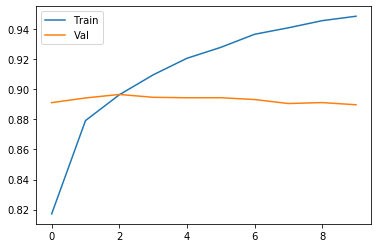

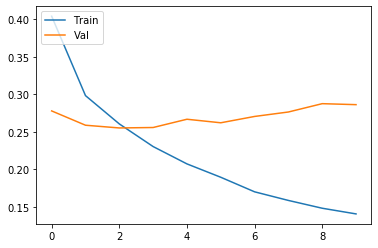

In [17]:
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [22]:
# mini batches Nadam optimizer with dropout and batch normalization
epochs = 10
model = keras.Sequential()
model.add(layers.Dense(32, input_dim=30000, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(layers.BatchNormalization())

model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN.model", monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                960032    
_________________________________________________________________
batch_normalization_31 (Batc (None, 32)                128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)               

In [23]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 32, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/32,epochs=100, callbacks=[checkpoint])

Epoch 1/100
3750/3750 [==============================] - 114s 30ms/step - loss: 0.8514 - accuracy: 0.7890 - val_loss: 0.5231 - val_accuracy: 0.8493

Epoch 00001: val_loss improved from inf to 0.52309, saving model to NN.model
Epoch 2/100
3750/3750 [==============================] - 160s 43ms/step - loss: 0.5687 - accuracy: 0.8221 - val_loss: 0.5355 - val_accuracy: 0.8444

Epoch 00002: val_loss did not improve from 0.52309
Epoch 3/100
3750/3750 [==============================] - 164s 44ms/step - loss: 0.5560 - accuracy: 0.8247 - val_loss: 0.5080 - val_accuracy: 0.8478

Epoch 00003: val_loss improved from 0.52309 to 0.50798, saving model to NN.model
Epoch 4/100
3750/3750 [==============================] - 166s 44ms/step - loss: 0.5471 - accuracy: 0.8262 - val_loss: 0.5278 - val_accuracy: 0.8310

Epoch 00004: val_loss did not improve from 0.50798
Epoch 5/100
3750/3750 [==============================] - 166s 44ms/step - loss: 0.5459 - accuracy: 0.8250 - val_loss: 0.4984 - val_accuracy: 0.8

3750/3750 [==============================] - 157s 42ms/step - loss: 0.5282 - accuracy: 0.8269 - val_loss: 0.4746 - val_accuracy: 0.8461

Epoch 00041: val_loss did not improve from 0.47103
Epoch 42/100
3750/3750 [==============================] - 157s 42ms/step - loss: 0.5266 - accuracy: 0.8283 - val_loss: 0.4763 - val_accuracy: 0.8489

Epoch 00042: val_loss did not improve from 0.47103
Epoch 43/100
3750/3750 [==============================] - 157s 42ms/step - loss: 0.5273 - accuracy: 0.8263 - val_loss: 0.4750 - val_accuracy: 0.8479

Epoch 00043: val_loss did not improve from 0.47103
Epoch 44/100
3750/3750 [==============================] - 157s 42ms/step - loss: 0.5282 - accuracy: 0.8273 - val_loss: 0.4659 - val_accuracy: 0.8507

Epoch 00044: val_loss improved from 0.47103 to 0.46591, saving model to NN.model
Epoch 45/100
3750/3750 [==============================] - 158s 42ms/step - loss: 0.5276 - accuracy: 0.8274 - val_loss: 0.5004 - val_accuracy: 0.8310

Epoch 00045: val_loss did not


Epoch 00081: val_loss did not improve from 0.46494
Epoch 82/100
3750/3750 [==============================] - 157s 42ms/step - loss: 0.5286 - accuracy: 0.8270 - val_loss: 0.4652 - val_accuracy: 0.8476

Epoch 00082: val_loss did not improve from 0.46494
Epoch 83/100
3750/3750 [==============================] - 158s 42ms/step - loss: 0.5275 - accuracy: 0.8267 - val_loss: 0.4918 - val_accuracy: 0.8445

Epoch 00083: val_loss did not improve from 0.46494
Epoch 84/100
3750/3750 [==============================] - 158s 42ms/step - loss: 0.5274 - accuracy: 0.8268 - val_loss: 0.4760 - val_accuracy: 0.8475

Epoch 00084: val_loss did not improve from 0.46494
Epoch 85/100
3750/3750 [==============================] - 158s 42ms/step - loss: 0.5262 - accuracy: 0.8288 - val_loss: 0.4886 - val_accuracy: 0.8421

Epoch 00085: val_loss did not improve from 0.46494
Epoch 86/100
3750/3750 [==============================] - 158s 42ms/step - loss: 0.5266 - accuracy: 0.8267 - val_loss: 0.4805 - val_accuracy: 0.

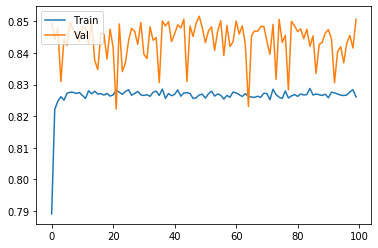

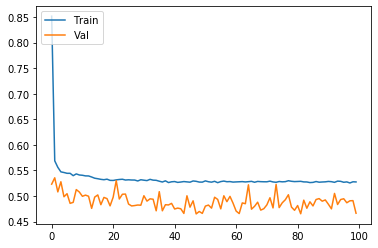

In [24]:
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Neural Net features added up

### importing data

In [4]:
### Constructing train features

import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'])

x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

from scipy import sparse

x_train = sparse.csr_matrix(x_train)
x_train.shape

x_train = sparse.hstack([x_train, tfidf_features])
x_train.shape

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(x_train.shape)

print(x_val.shape)

160000


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(120000, 30000)
(40000, 30000)


In [311]:
### Constructing train features

import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

from sklearn.feature_extraction.text import CountVectorizer

tfidf = CountVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'])

x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

from scipy import sparse

x_train = sparse.csr_matrix(x_train)
x_train.shape

x_train = sparse.hstack([x_train, tfidf_features])
x_train.shape

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(x_train.shape)

print(x_val.shape)

160000


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(120000, 30000)
(40000, 30000)


In [52]:
from sklearn.preprocessing import normalize

x_train = normalize(x_train)
x_val = normalize(x_val)

In [316]:
logreg = LogisticRegression(random_state=42, max_iter=2000)

x_train_scaled = normalize(x_train)
x_val_scaled = normalize(x_val)

logreg.fit(x_train_scaled, y_train)

print(logreg.score(x_train_scaled, y_train))
print(logreg.score(x_val_scaled, y_val))

0.9021166666666667
0.8876


In [314]:
x_train.shape

(120000, 30000)

### Neural net training

In [317]:
import keras

y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='int32')
y_val = keras.utils.to_categorical(y_val, num_classes=2, dtype='int32')

In [55]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [26]:
from keras import layers

epochs = 10
model = keras.Sequential()
model.add(layers.Dense(16, input_dim=30000, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(32, activation='relu', ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN1.model", monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                480016    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [27]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 32, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/32,epochs=10, callbacks=[checkpoint])

Epoch 1/10
3750/3750 [==============================] - 76s 20ms/step - loss: 0.4443 - accuracy: 0.7965 - val_loss: 0.3010 - val_accuracy: 0.8780

Epoch 00001: val_loss improved from inf to 0.30105, saving model to NN1.model
Epoch 2/10
3750/3750 [==============================] - 77s 20ms/step - loss: 0.3229 - accuracy: 0.8710 - val_loss: 0.2836 - val_accuracy: 0.8831

Epoch 00002: val_loss improved from 0.30105 to 0.28357, saving model to NN1.model
Epoch 3/10
3750/3750 [==============================] - 80s 21ms/step - loss: 0.2913 - accuracy: 0.8848 - val_loss: 0.2791 - val_accuracy: 0.8910

Epoch 00003: val_loss improved from 0.28357 to 0.27910, saving model to NN1.model
Epoch 4/10
3750/3750 [==============================] - 83s 22ms/step - loss: 0.2706 - accuracy: 0.8951 - val_loss: 0.2855 - val_accuracy: 0.8888

Epoch 00004: val_loss did not improve from 0.27910
Epoch 5/10
3750/3750 [==============================] - 83s 22ms/step - loss: 0.2583 - accuracy: 0.9019 - val_loss: 0.2

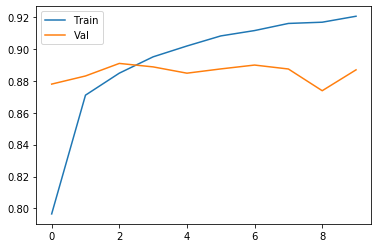

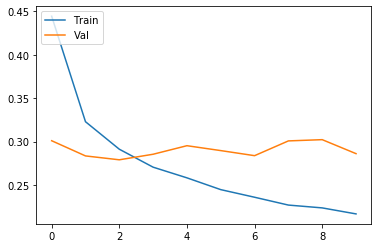

In [28]:
import matplotlib.pyplot as plt

plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [225]:
model = keras.Sequential()
model.add(layers.Dense(64, input_dim=30000))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN2.model", monitor='val_loss', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 64)                1920064   
_________________________________________________________________
batch_normalization_49 (Batc (None, 64)                256       
_________________________________________________________________
activation_22 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_50 (Batc (None, 64)                256       
_________________________________________________________________
activation_23 (Activation)   (None, 64)              

In [228]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 32, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/32,epochs=10, callbacks=[checkpoint])

Epoch 1/10
3750/3750 [==============================] - 97s 26ms/step - loss: 0.3722 - accuracy: 0.8396 - val_loss: 0.2678 - val_accuracy: 0.8910

Epoch 00001: val_loss improved from inf to 0.26779, saving model to NN2.model
Epoch 2/10
3750/3750 [==============================] - 162s 43ms/step - loss: 0.2769 - accuracy: 0.8871 - val_loss: 0.2537 - val_accuracy: 0.8963

Epoch 00002: val_loss improved from 0.26779 to 0.25369, saving model to NN2.model
Epoch 3/10
3750/3750 [==============================] - 222s 59ms/step - loss: 0.2337 - accuracy: 0.9082 - val_loss: 0.2547 - val_accuracy: 0.8952

Epoch 00003: val_loss did not improve from 0.25369
Epoch 4/10
3750/3750 [==============================] - 228s 61ms/step - loss: 0.2021 - accuracy: 0.9220 - val_loss: 0.2575 - val_accuracy: 0.8951

Epoch 00004: val_loss did not improve from 0.25369
Epoch 5/10
3750/3750 [==============================] - 232s 62ms/step - loss: 0.1736 - accuracy: 0.9337 - val_loss: 0.2632 - val_accuracy: 0.8941


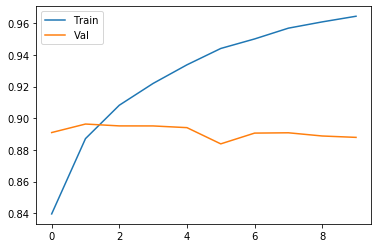

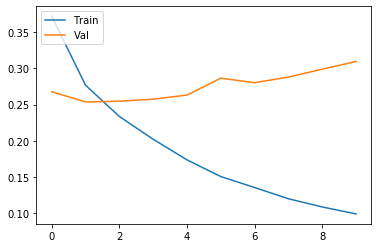

In [229]:
import matplotlib.pyplot as plt

plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [318]:
model = keras.Sequential()
model.add(layers.Dense(128, input_dim=30000))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN4.model", monitor='val_loss', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 128)               3840128   
_________________________________________________________________
batch_normalization_61 (Batc (None, 128)               512       
_________________________________________________________________
activation_36 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_62 (Batc (None, 128)               512       
_________________________________________________________________
activation_37 (Activation)   (None, 128)             

In [319]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 64, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/64,epochs=10, callbacks=[checkpoint])

Epoch 1/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.3652 - accuracy: 0.8424 - val_loss: 0.2891 - val_accuracy: 0.8806

Epoch 00001: val_loss improved from inf to 0.28910, saving model to NN4.model
Epoch 2/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.2470 - accuracy: 0.9026 - val_loss: 0.2806 - val_accuracy: 0.8883

Epoch 00002: val_loss improved from 0.28910 to 0.28059, saving model to NN4.model
Epoch 3/10
1875/1875 [==============================] - 147s 79ms/step - loss: 0.2001 - accuracy: 0.9220 - val_loss: 0.2841 - val_accuracy: 0.8889

Epoch 00003: val_loss did not improve from 0.28059
Epoch 4/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.1660 - accuracy: 0.9377 - val_loss: 0.2903 - val_accuracy: 0.8895

Epoch 00004: val_loss did not improve from 0.28059
Epoch 5/10
1875/1875 [==============================] - 236s 126ms/step - loss: 0.1383 - accuracy: 0.9485 - val_loss: 0.3121 - val_accuracy: 0.8827


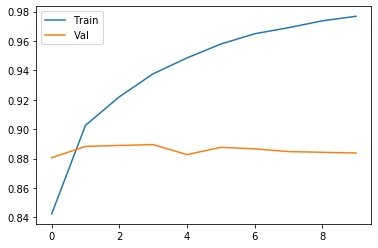

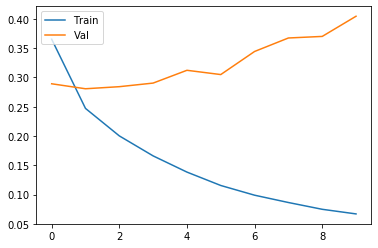

In [320]:
import matplotlib.pyplot as plt

plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Combining Features

In [255]:
import keras

chosen_model = keras.models.load_model('NN3.model')

In [71]:
chosen_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 32)                960032    
_________________________________________________________________
batch_normalization_43 (Batc (None, 32)                128       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_44 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)               

In [256]:
capped_model = keras.Sequential()

for layer in chosen_model.layers[:-4]:
    capped_model.add(layer)
    
capped_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               3840128   
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_56 (Batc (None, 128)               512       
_________________________________________________________________
activation_30 (Activation)   (None, 128)             

In [257]:
from tqdm.notebook import tqdm_notebook as tqdm

y_predict_train = []

for i in tqdm(range(x_train.shape[0])):
    array = x_train[i].toarray()
    prediction = capped_model.predict(array)
    y_predict_train.append(prediction)

In [258]:
y_predict_train = np.array(y_predict_train)
y_predict_train.shape

(120000, 1, 256)

In [260]:
y_predict_train = y_predict_train.reshape((120000, 256))
y_predict_train.shape

(120000, 256)

#### PCA to reduce dimensions of TFIDF

In [261]:
x_train_tfidf = x_train[:,100:]
x_train_tfidf.shape

(120000, 29900)

In [305]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=25)

svd_data = svd.fit_transform(x_train)

In [287]:
svd_data.shape

(120000, 500)

In [137]:
y_predict_train.shape

(120000, 64)

#### Combine PCA result with last layer of NN

In [306]:
from scipy import sparse

x_train_new = np.hstack([svd_data, y_predict_train])
x_train_new.shape

(120000, 281)

In [264]:
y_train = np.argmax(y_train, axis=1)
y_train

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
x_train = normalize(x_train)

svm_model = svm.fit(x_train, y_train)

In [58]:
svm_model.score(x_train, y_train)

0.865975

In [265]:
#same process to validation set

from tqdm.notebook import tqdm_notebook as tqdm

y_predict_val = []

for i in tqdm(range(x_val.shape[0])):
    array = x_val[i].toarray()
    prediction = capped_model.predict(array)
    y_predict_val.append(prediction)

y_predict_val = np.array(y_predict_val)

In [307]:
x_val_tfidf = x_val[:,100:]

svd_data_val = svd.transform(x_val)

In [308]:
y_predict_val = y_predict_val.reshape((40000, 256))

x_val_new = np.hstack([svd_data_val, y_predict_val])

#y_val = np.argmax(y_val, axis=1)
y_val

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [269]:
y_val = np.argmax(y_val, axis=1)

In [74]:
svm_model.score(x_val, y_val)

0.526775

### Logistic Regression with combined features

In [270]:
x_train_new.shape

(120000, 456)

In [273]:
scaler = StandardScaler()

#x_train_new = x_train_new.toarray()
#x_val_new = x_val_new.toarray()

print(x_train_new.shape)
print(x_val_new.shape)

x_train_normalized = scaler.fit_transform(x_train_new)
x_val_normalized = scaler.transform(x_val_new)

(120000, 456)
(40000, 456)


In [223]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(random_state=42, max_iter=8000)

log_model.fit(x_train_new, y_train)

print(log_model.score(x_train_new, y_train))
print(log_model.score(x_val_new, y_val))

0.8797916666666666
0.876625


In [243]:
#200 + 128

log_model = LogisticRegression(random_state=42, max_iter=8000)

log_model.fit(x_train_new, y_train)

print(log_model.score(x_train_new, y_train))
print(log_model.score(x_val_new, y_val))

0.9488916666666667
0.89605


In [249]:
#500 + 128

log_model = LogisticRegression(random_state=42, max_iter=8000)

log_model.fit(x_train_new, y_train)

print(log_model.score(x_train_new, y_train))
print(log_model.score(x_val_new, y_val))

0.9503416666666666
0.895075


In [274]:
# 200 + 256

log_model = LogisticRegression(random_state=42, max_iter=8000)

log_model.fit(x_train_new, y_train)

print(log_model.score(x_train_new, y_train))
print(log_model.score(x_val_new, y_val))

0.95515
0.89615


In [224]:
log_model.fit(y_predict_train, y_train)

print(log_model.score(y_predict_val, y_val))
print(log_model.score(y_predict_train, y_train))

0.776825
0.7746416666666667


In [310]:
# Try random forest on 0 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(y_predict_train, y_train)

print(rf.score(y_predict_train, y_train))
print(rf.score(y_predict_val, y_val))

0.948075
0.89915


In [309]:
# Try random forest on 25 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9480083333333333
0.899125


In [304]:
# Try random forest on 50 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9479916666666667
0.899225


In [299]:
# Try random forest on 100 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.947975
0.899125


In [282]:
# Try random forest on 200 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9479333333333333
0.89915


In [288]:
# Try random forest on 500 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9479333333333333
0.89915


In [294]:
# Try random forest on 1000 + 256

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9479416666666667
0.89915


In [278]:
# XGB on 200 + 256

from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(x_train_new, y_train)

print(xgb.score(x_train_new, y_train))
print(xgb.score(x_val_new, y_val))

0.9870666666666666
0.897825


In [ ]:
# 0.89735 (100 W2V, 100 SVD-TFIDF, 64 Last Layer Output)

### Neural Net with combined features

In [25]:
import keras

y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='int32')
y_val = keras.utils.to_categorical(y_val, num_classes=2, dtype='int32')

In [25]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

#### Neural net with previous net output features only

In [45]:
from keras import layers

epochs = 10
model = keras.Sequential()
model.add(layers.Dense(2, input_dim=32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(4, activation='relu', ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN2.model", monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 2)                 66        
_________________________________________________________________
batch_normalization_25 (Batc (None, 2)                 8         
_________________________________________________________________
dropout_21 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 6         
_________________________________________________________________
batch_normalization_26 (Batc (None, 2)                 8         
_________________________________________________________________
dropout_22 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                

In [36]:
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
y_predict_train1 = scaler1.fit_transform(y_predict_train)
y_predict_val1 = scaler1.transform(y_predict_val)

In [47]:
model1 = model.fit(y_predict_train1, y_train, validation_data=(y_predict_val1, y_val), epochs=10, callbacks=[checkpoint])

Train on 120000 samples, validate on 40000 samples
Epoch 1/10
120000/120000 [==============================] - 48s 399us/step - loss: 0.6807 - accuracy: 0.5651 - val_loss: 0.6768 - val_accuracy: 0.5749

Epoch 00001: val_loss improved from 0.67863 to 0.67681, saving model to NN2.model
Epoch 2/10
120000/120000 [==============================] - 51s 427us/step - loss: 0.6809 - accuracy: 0.5646 - val_loss: 0.6775 - val_accuracy: 0.5710

Epoch 00002: val_loss did not improve from 0.67681
Epoch 3/10
120000/120000 [==============================] - 58s 480us/step - loss: 0.6805 - accuracy: 0.5643 - val_loss: 0.6764 - val_accuracy: 0.5763

Epoch 00003: val_loss improved from 0.67681 to 0.67639, saving model to NN2.model
Epoch 4/10
120000/120000 [==============================] - 131s 1ms/step - loss: 0.6800 - accuracy: 0.5691 - val_loss: 0.6773 - val_accuracy: 0.5749

Epoch 00004: val_loss did not improve from 0.67639
Epoch 5/10
120000/120000 [==============================] - 120s 998us/step 

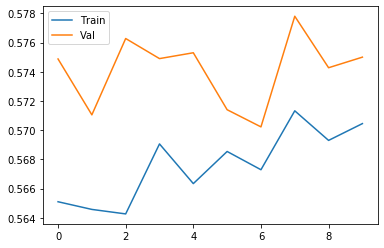

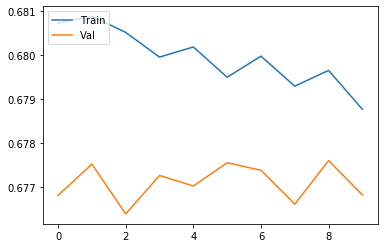

In [48]:
import matplotlib.pyplot as plt

plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [43]:
model = LogisticRegression(random_state=42, max_iter=2000)

y_train_label = np.argmax(y_train, 1)
y_val_label = np.argmax(y_val, 1)

model.fit(y_predict_train, y_train_label)
model.score(y_predict_val, y_val_label)

0.5747

In [44]:
model.score(y_predict_train, y_train_label)

0.582125

## RNN

In [62]:
import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

x_train = df['text']

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(len(x_train))
print(len(x_val))

160000
120000
40000


In [63]:
from keras.preprocessing.text import Tokenizer

max_length = 100

t = Tokenizer()
t.fit_on_texts(x_train)

encoded_docs = t.texts_to_sequences(x_train)
encoded_val = t.texts_to_sequences(x_val)

word_index = t.word_index

In [64]:
from keras.preprocessing.sequence import pad_sequences

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_val = pad_sequences(encoded_val, maxlen=max_length, padding='post')

In [3]:
num_words = len(word_index) + 1

count =0 

embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i > num_words:
        continue
    try:
        embedding_matrix[i] = model_w2v[word]
    except KeyError as e:
        count = count + 1

print('Found ' + str(count) + ' unknown vocab')

C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Found 150897 unknown vocab


In [66]:
num_words

187803

In [67]:
len(model_w2v.wv.vocab)

36974

In [68]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)# loading
#with open('tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

In [69]:
model_w2v.save('model_w2v.bin')

### LSTM

In [4]:
import keras

y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='int32')
y_val = keras.utils.to_categorical(y_val, num_classes=2, dtype='int32')

In [17]:
emb = model_w2v.wv.get_keras_embedding(train_embeddings=False)

In [71]:
# Word2Vec Embedding

import keras

from keras.models import Sequential
from keras.layers import Embedding, Flatten, LSTM, Dense, Dropout, SpatialDropout1D
from keras.initializers import Constant

model = Sequential()
e = Embedding(embedding_matrix.shape[0], 100, embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=True)

model.add(e)
#model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.3, recurrent_dropout=0.3))
model.add(LSTM(64, return_sequences=False, activation='tanh', dropout=0.3, recurrent_dropout=0.3))


model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN_LSTM.model", monitor='val_loss', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          18780300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 18,947,086
Trainable params: 18,947,086
Non-trainable params: 0
_________________________________________________________________


In [72]:
model = model.fit(padded_docs, y_train, batch_size=512, epochs=25, validation_data=[padded_val, y_val], callbacks=[checkpoint])

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 780s 6ms/step - loss: 0.5792 - accuracy: 0.7061 - val_loss: 0.5362 - val_accuracy: 0.7514

Epoch 00001: val_loss improved from inf to 0.53621, saving model to NN_LSTM.model
Epoch 2/25
120000/120000 [==============================] - 732s 6ms/step - loss: 0.5634 - accuracy: 0.7264 - val_loss: 0.5400 - val_accuracy: 0.7595

Epoch 00002: val_loss did not improve from 0.53621
Epoch 3/25
120000/120000 [==============================] - 717s 6ms/step - loss: 0.5737 - accuracy: 0.7111 - val_loss: 0.5435 - val_accuracy: 0.7411

Epoch 00003: val_loss did not improve from 0.53621
Epoch 4/25
120000/120000 [==============================] - 717s 6ms/step - loss: 0.5957 - accuracy: 0.6830 - val_loss: 0.6195 - val_accuracy: 0.6636

Epoch 00004: val_loss did not improve from 0.53621
Epoch 5/25
120000/120000 [==============================] - 718s 6ms/step - loss: 0.6306 - accuracy: 0.6469 - 

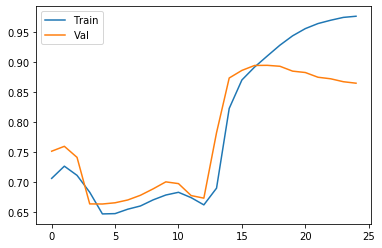

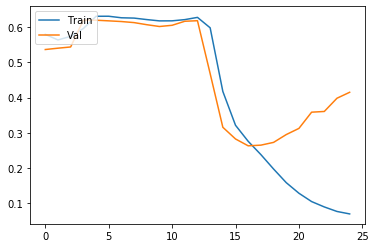

In [73]:
import matplotlib.pyplot as plt

plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [58]:
# from keras.models import Sequential
from keras.layers import Embedding, Flatten, LSTM, Dense, Dropout
from keras.initializers import Constant

model = keras.models.Sequential()
e = Embedding(len(word_index), 100, input_length = max_length, trainable=True)

model.add(e)
model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.3, recurrent_dropout=0.3))
model.add(LSTM(64, return_sequences=False, activation='tanh', dropout=0.3, recurrent_dropout=0.3))


model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN_LSTM_1.model", monitor='val_loss', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          18771100  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 18,937,886
Trainable params: 18,937,886
Non-trainable params: 0
_________________________________________________________________


In [59]:
model = model.fit(padded_docs, y_train, batch_size=512, epochs=25, validation_data=[padded_val, y_val], callbacks=[checkpoint])

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 734s 6ms/step - loss: 0.6723 - accuracy: 0.5445 - val_loss: 0.5683 - val_accuracy: 0.7457

Epoch 00001: val_loss improved from inf to 0.56830, saving model to NN_LSTM_1.model
Epoch 2/25
120000/120000 [==============================] - 738s 6ms/step - loss: 0.5723 - accuracy: 0.7363 - val_loss: 0.5721 - val_accuracy: 0.7305

Epoch 00002: val_loss did not improve from 0.56830
Epoch 3/25
120000/120000 [==============================] - 738s 6ms/step - loss: 0.5965 - accuracy: 0.6979 - val_loss: 0.5981 - val_accuracy: 0.6763

Epoch 00003: val_loss did not improve from 0.56830
Epoch 4/25
120000/120000 [==============================] - 740s 6ms/step - loss: 0.6364 - accuracy: 0.6107 - val_loss: 0.6538 - val_accuracy: 0.5738

Epoch 00004: val_loss did not improve from 0.56830
Epoch 5/25
 68608/120000 [================>.............] - ETA: 4:45 - loss: 0.6388 - accuracy: 0.6025

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [5]:
# Word2Vec Embedding

import keras

from keras.models import Sequential
from keras.layers import Embedding, Flatten, LSTM, Dense, Dropout, SpatialDropout1D
from keras.initializers import Constant

model = Sequential()
e = Embedding(embedding_matrix.shape[0], 100, embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=True)

model.add(e)
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.3, recurrent_dropout=0.3))
model.add(LSTM(64, return_sequences=False, activation='tanh', dropout=0.3, recurrent_dropout=0.3))


model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("NN_LSTM1.model", monitor='val_loss', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          18780300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 18,947,086
Trainable params: 18,947,086
Non-trainable params: 0
_________________________________________________________________


In [9]:
model = model.fit(padded_docs, y_train, batch_size=512, epochs=25, validation_data=[padded_val, y_val], callbacks=[checkpoint])

AttributeError: 'History' object has no attribute 'fit'

In [ ]:
model = keras.models.load_model('NN_LSTM1.model')

model2 = model.fit(padded_docs, y_train, batch_size=512, epochs=25, validation_data=[padded_val, y_val], callbacks=[checkpoint])

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 170s 1ms/step - loss: 0.2267 - accuracy: 0.9111 - val_loss: 0.2736 - val_accuracy: 0.8901

Epoch 00001: val_loss did not improve from 0.27017
Epoch 2/25
120000/120000 [==============================] - 924s 8ms/step - loss: 0.2203 - accuracy: 0.9141 - val_loss: 0.2748 - val_accuracy: 0.8907

Epoch 00002: val_loss did not improve from 0.27017
Epoch 3/25
120000/120000 [==============================] - 889s 7ms/step - loss: 0.2146 - accuracy: 0.9168 - val_loss: 0.2777 - val_accuracy: 0.8911

Epoch 00003: val_loss did not improve from 0.27017
Epoch 4/25
120000/120000 [==============================] - 823s 7ms/step - loss: 0.2075 - accuracy: 0.9193 - val_loss: 0.2820 - val_accuracy: 0.8900

Epoch 00004: val_loss did not improve from 0.27017
Epoch 5/25
120000/120000 [==============================] - 824s 7ms/step - loss: 0.1993 - accuracy: 0.9242 - val_loss: 0.2800 - val_accuracy

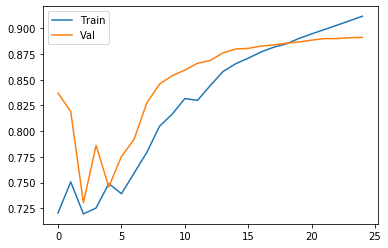

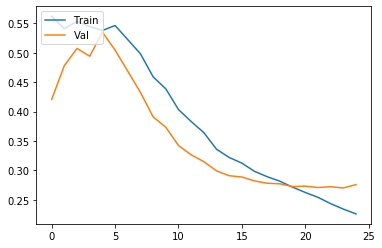

In [7]:
import matplotlib.pyplot as plt

plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Combine with PCA W2V and TFIDF

In [1]:
import keras

chosen_model = keras.models.load_model('NN_LSTM.model')
chosen_model.summary()

Using TensorFlow backend.
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          18780300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 18,947,086
Trainable params: 18,947,086
Non-trainable params: 0
_________________________________________________________________


In [2]:
capped_model = keras.Sequential()

for layer in chosen_model.layers[:-1]:
    capped_model.add(layer)
    
print(capped_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          18780300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
Total params: 18,946,956
Trainable params: 18,946,956
Non-trainable params: 0
_________________________________________________________________
None


In [3]:
### Constructing train features

import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
df = df.reset_index(drop=True)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec.load('model_w2v.bin')

#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)
        
text_avg_vec = np.array(text_avg_vec).reshape(-1, 100)
x_train = pd.DataFrame(text_avg_vec)

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)
        
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

train_indices = x_train.index
val_indices = x_val.index

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'].loc[train_indices])
tfidf_val = tfidf.transform(df['text'].loc[val_indices])

from scipy import sparse

x_train = sparse.csr_matrix(x_train)
x_val = sparse.csr_matrix(x_val)

print(x_train.shape)

x_train = sparse.hstack([x_train, tfidf_features])
x_val = sparse.hstack([x_val, tfidf_val])

from keras.preprocessing.text import Tokenizer

max_length = 100

import pickle

with open('tokenizer.pickle', 'rb') as handle:
    t = pickle.load(handle)

encoded_docs = t.texts_to_sequences(df['text'].loc[train_indices])
encoded_val = t.texts_to_sequences(df['text'].loc[val_indices])

word_index = t.word_index

from keras.preprocessing.sequence import pad_sequences

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_val = pad_sequences(encoded_val, maxlen=max_length, padding='post')

print('done')

160000


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(120000, 100)
done


In [137]:
#padded_docs = np.reshape(padded_docs, (120000,100,100))
#padded_val = np.reshape(padded_val, (40000,100,100))
pad.shape

(1, 100)

In [153]:
padded_docs.shape

(120000, 100)

In [135]:
pad = np.reshape(padded_docs[0], (1,100))
y_predict_train = capped_model.predict(pad)

In [4]:
from tqdm.notebook import tqdm_notebook as tqdm

y_predict_train = capped_model.predict(padded_docs)

y_predict_train = np.array(y_predict_train)

y_predict_train = y_predict_train.reshape((120000, 64))
y_predict_train.shape

#### PCA to reduce dimensions of TFIDF

#x_train_tfidf = x_train[:,100:]
#x_train_tfidf.shape

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200)

svd_data = svd.fit_transform(x_train)

svd_data.shape

y_predict_train.shape

#### Combine PCA result with last layer of NN

from scipy import sparse

x_train_new = np.hstack([svd_data, y_predict_train])
x_train_new.shape

#y_train = np.argmax(y_train, axis=1)
y_train

#x_train = normalize(x_train)


#same process to validation set

from tqdm.notebook import tqdm_notebook as tqdm

y_predict_val = capped_model.predict(padded_val)

y_predict_val = np.array(y_predict_val)

#x_val_tfidf = x_val[:,100:]

svd_data_val = svd.transform(x_val)

y_predict_val = y_predict_val.reshape((40000, 64))

x_val_new = np.hstack([svd_data_val, y_predict_val])

#y_val = np.argmax(y_val, axis=1)
y_val

#y_val = np.argmax(y_val, axis=1)

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [156]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(random_state=42, max_iter=8000)

log_model.fit(x_train_new, y_train)

print(log_model.score(x_train_new, y_train))
print(log_model.score(x_val_new, y_val))

0.8949916666666666
0.892725


In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.8927333333333334
0.89325


In [6]:
rf = RandomForestClassifier(max_depth=10)

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9078
0.893225


In [7]:
rf = RandomForestClassifier()

rf.fit(x_train_new, y_train)

print(rf.score(x_train_new, y_train))
print(rf.score(x_val_new, y_val))

0.9999833333333333
0.892425


### Dense net output + RNN output

In [157]:
chosen_model = keras.models.load_model('NN3.model')

chosen_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               3840128   
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_56 (Batc (None, 128)               512       
_________________________________________________________________
activation_30 (Activation)   (None, 128)             

In [163]:
# Dense net output + RNN output

capped_model = keras.Sequential()

for layer in chosen_model.layers[:-4]:
    capped_model.add(layer)
    
capped_model.summary()

x_train = x_train.tocsr()
x_val = x_val.tocsr()

from tqdm.notebook import tqdm_notebook as tqdm

y_predict_train_dense = []

for i in tqdm(range(x_train.shape[0])):
    array = x_train[i].toarray()
    prediction = capped_model.predict(array)
    y_predict_train_dense.append(prediction)

y_predict_train_dense = np.array(y_predict_train_dense)

y_predict_train_dense = y_predict_train_dense.reshape((120000, 256))

x_train_new_2 = np.hstack([y_predict_train_dense, y_predict_train])

#same process to validation set

y_predict_val_dense = []

for i in tqdm(range(x_val.shape[0])):
    array = x_val[i].toarray()
    prediction = capped_model.predict(array)
    y_predict_val_dense.append(prediction)

y_predict_val_dense = np.array(y_predict_val_dense)

y_predict_val_dense = y_predict_val_dense.reshape((40000, 256))

x_val_new_2 = np.hstack([y_predict_val_dense, y_predict_val])

#y_val = np.argmax(y_val, axis=1)
y_val

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               3840128   
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_56 (Batc (None, 128)               512       
_________________________________________________________________
activation_30 (Activation)   (None, 128)              

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [164]:
log_model = LogisticRegression(random_state=42, max_iter=8000)

log_model.fit(x_train_new_2, y_train)

print(log_model.score(x_train_new_2, y_train))
print(log_model.score(x_val_new_2, y_val))

0.8929166666666667
0.8917


## CNN

In [2]:
### Constructing train features

import pandas as pd
import numpy as np
import csv
import sys
import nltk
from nltk.corpus import stopwords
import glob
import os
import string

#Load training file

text_file = open("train.txt.txt", "r", encoding="utf8")
lines = text_file.read().split('\n')

labels = []
for item in lines:
    first_four_letters = item[:10]
    if first_four_letters == '__label__1':
        labels.append(int(1))
    else:
        labels.append(int(2))
        
def remove_label(s):
    return s[11:]
lines = [remove_label(s) for s in lines]

df = pd.DataFrame()
df['text'] = lines
df['label'] = labels

df = df.sample(160000)
print(len(df))
df.head()

#Clean text

stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#lowercase and remove punctuation, remove stopwords        
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('-', ' ')
df['text'] = df['text'].str.split(' ')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(', '.join)
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
df['text'] = df['text'].str.replace('\\', ' ')


#Train Word2Vec

from gensim.models import Word2Vec

text = [row.split() for row in df['text']]
model_w2v = Word2Vec(text)

model_w2v.save('model_w2v.bin')

#Average Word2Vec Vectors for BOW

from tqdm import tqdm_notebook as tqdm

text_vec = []
text_avg_vec = []
count = 0
for row in tqdm(range(len(text))):
    [word.split(' ', 1) for word in text[row]]
  
    for i in range(len(text[row])):
        try:
            text_vec.append(model_w2v[text[row][i]])
            count = count + 1
        except KeyError as e:
            text_vec.append([0]*100)
  
    average = np.add.reduce(text_vec)
    if count==0:
        count = 1
    average = np.divide(average, count)
    text_avg_vec.append(average)
    text_vec = []
    count = 0

for i in range(len(text_avg_vec)):
    if type(text_avg_vec[i]) != np.ndarray:
        text_avg_vec[i] = np.zeros(100)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=29900)

tfidf_features = tfidf.fit_transform(df['text'])

x_train = text_avg_vec
x_train = np.array(x_train).reshape(-1, 100)

from scipy import sparse

x_train = sparse.csr_matrix(x_train)
x_train.shape

x_train = sparse.hstack([x_train, tfidf_features])
x_train.shape

df['label'] = df['label'] - 1

y_train= np.asarray(df.label)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=40000, random_state=42)

print(x_train.shape)

#print(x_val.shape)

160000


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(120000, 30000)


In [3]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        X_batch = np.reshape(X_batch, (X_batch.shape[0], X_batch.shape[1], 1))
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [81]:
x_val.shape

(40000, 30000)

In [5]:
x_val = x_val.toarray()
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

In [7]:
import keras

y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='int32')
y_val = keras.utils.to_categorical(y_val, num_classes=2, dtype='int32')

Using TensorFlow backend.
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\danie\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [8]:
#CNN Training

shape = (x_train.shape[1], 1)
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=shape))
model.add(keras.layers.Conv1D(32, kernel_size=3, activation='relu'))

model.add(keras.layers.MaxPooling1D(pool_size=2))
          
model.add(keras.layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(keras.layers.Conv1D(64, kernel_size=3, activation='relu'))
          
model.add(keras.layers.MaxPooling1D(pool_size=2))
          
model.add(keras.layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(keras.layers.Conv1D(128, kernel_size=3, activation='relu'))
          
model.add(keras.layers.MaxPooling1D(pool_size=2))
          
model.add(keras.layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(keras.layers.Conv1D(256, kernel_size=3, activation='relu'))
          
model.add(keras.layers.MaxPooling1D(pool_size=5))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
          
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(2, activation='relu'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("CNN.model", monitor='val_loss', verbose=1, save_best_only=True)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 29998, 32)         128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 29996, 32)         3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14998, 32)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14996, 64)         6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14994, 64)         12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7497, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7495, 128)       

In [10]:
model1 = model.fit_generator(generator=batch_generator(x_train, y_train, 32, True), validation_data=(x_val, y_val), steps_per_epoch=(x_train.shape[0])/32,epochs=25)

Epoch 1/25
 680/3750 [====>.........................] - ETA: 2:01:38 - loss: 0.7412 - accuracy: 0.7585

KeyboardInterrupt: 